In [2]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

# Weather radar image

In [5]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In this exercise I will study a polynomial fit to a radar image of precipitation. The image was captured using my own module nedborradar.py which connects to:

https://kartkatalog.geonorge.no/metadata/meteorologisk-kartinformasjon/c247f4a3-56a8-49fa-afe0-a0329b9453e1

and downloads a snapshot of weather radar image for Norway. The image is then converted to grayscale so that more rain is represented by higher numbers. It must be noted that the resulting image is not (yet) represented by physical units (such as mm/h), but by numbers between 0 and 1. 0 means no rain and 1 represents an ammount slightly more than this snapshot's maximum rain. As this is a matter of scaling it should not affect the polynomial fit after scaling. 

In [36]:
# The following code downloads a new snapshot of precipitation from the weather radar
# import nedborradar
# import skimage
#x = nedborradar.RadarImage('Eastern Norway')
#Forbedring: Røde flekker for høy nedbørintensitet fanges ikkje opp. !
#norge_radar = x.get_map()
#radar = x.get_grayscale()
#np.save("nedbor_radar.npy", radar)
#np.save("Norge radar.npy", norge_radar)

In [37]:
radar = np.load("nedbor_radar.npy") # from 2021-10-06 kl 11:45

### Plot rain and a map over Oslo

![Precipitation over Oslo region](bilde_norge.png)

### Plot grayscale rain

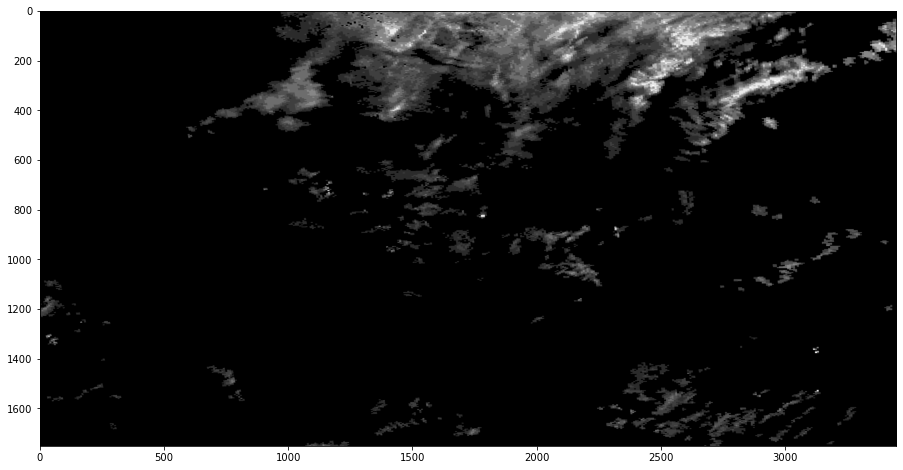

In [38]:
fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(radar, cmap='gray')
plt.show()

In [ ]:
# strategi, prøv å tilpass terrenget med OLS, ridge og Lasso. Bruk CV for resampling. 

In [30]:
radar.shape

(1751, 3447)